# Random Forest

The Random Forest uses multiple decsion trees, to classify data. The RF  model operates by using a multitude of decision trees where each tree uses a random sample of features to classify and will cast a vote on what classification that the data will be in. Once each decision tree has voted, the majority vote is what the data will be grouped as. 

#### Importing Libraries & Data

In [11]:
import pandas as pd
import json
import numpy as np
import pickle

import time
np.random.seed(42)
from numpy.core.umath_tests import inner1d

from sklearn.feature_extraction import stop_words
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

import regex as re
import matplotlib.pyplot as plt

In [12]:
X = pd.read_csv('../Data/X.csv')
y = pd.read_csv('../Data/y.csv', header = None)

## Merging  my text and Train test splitting

In [13]:
X_corpus  = X['selftext'] + ' ' + X['title']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_corpus,y)

In [15]:
my_stopwords = list(stop_words.ENGLISH_STOP_WORDS) + ['crypto' , 'cryptocurrency' , 'cryptocurrencies', 'blockchain','bitcoin'
              ,'stock' , 'stocks'
             , 'https', 'io','fintel','amp','com','13d','8209','08','gt','www','000','http','07',
             'x200b','daex', 'click']

## Setting hyperparameters for GridSearch

####  1) 'n_estimators' =  The number of Decisions Trees that my Grid Search will produce
####  2) ' min_samples_split' = The Minimum number of samples required to split an internal node
####  3) ' max_featuers' = The maximum number of featuers that the TFIFD should use

I chose these hyperparameters because for n_estimators, usally the more decision trees it has, the better that model should do

In [16]:
params = {'RF__n_estimators' : [100,130,150],
          'RF__min_samples_split': [2 , 3 , 4],
          'TFIDF__max_features': [500,700,1000]}

## A random forest model obtains a random subset of features and each subset uses the featuers for a decision tree. At the end it aggregate the decision trees and votes on which clasiication the data goes, and the majority vote is where the data is classified.

### We would want to use a random forest in the case that takes fewer assumption about data and less overfit 

### Setting pipeline with TFIDF and Random Forest

A Pipeline is a function that takes in operations and will run all operations give and give an output.

In [17]:
pipe = Pipeline([
    ('TFIDF', TfidfVectorizer(stop_words=my_stopwords)),
    ('RF', RandomForestClassifier())
])

### GridSearch with my Pipe and parameters

Gridsearch takes in all the parameters and run all possible models with the set parameters and once its done, it chooses the best parameters for the specific data and returns that value and also gives you what the best params were

In [18]:
gs = GridSearchCV(pipe, params)

In [19]:
y_train_good = y_train.values.ravel()

In [20]:
gs.fit(X_train, y_train_good)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('TFIDF', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'RF__n_estimators': [100, 130, 150], 'RF__min_samples_split': [2, 3, 4], 'TFIDF__max_features': [500, 700, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Best parameters to use for model

In [21]:
gs.best_params_

{'RF__min_samples_split': 3,
 'RF__n_estimators': 150,
 'TFIDF__max_features': 1000}

In [22]:
gs.score(X_train, y_train)

0.9968553459119497

In [23]:
gs.score(X_test, y_test)

0.8606403013182674

In [24]:
with open('../Data/gs.pkl', 'wb+') as f:
    pickle.dump(gs, f)

## Feature importance shows me the most important features(words) that help the decision tree make decisions on where to split and where to put certain posts

In [25]:
feat_importance = pd.DataFrame(gs.best_estimator_.named_steps['RF'].feature_importances_, 
             gs.best_estimator_.named_steps['TFIDF'].get_feature_names(), 
             columns=['importance'])

#### Viewing my Feature importance

In [26]:
(feat_importance['importance']==0).sum()

44

In [27]:
feat_importance.shape

(1000, 1)

In [28]:
feat_importance.sort_values('importance', ascending=False).head(10)

,importance
company,0.030219
earnings,0.027027
market,0.024759
thoughts,0.022923
invest,0.019490
investing,0.019402
buy,0.019361
trade,0.014680
think,0.013388
today,0.013361


Talk about what these numbers mean 

## Creating Dataframe with the probability that a post in a certain is classified in a certain class, along with what true class it belonged to

In [29]:
proba_df = pd.DataFrame(X_test)
proba_df.reset_index(drop=True, inplace=True)

In [30]:
proba_df['proba'] = gs.predict_proba(X_test)[:, 1]

In [31]:
proba_df['true_y'] = y_test.reset_index(drop=True)

## False Negatives

My False Negatives posts are the post that were put in our '0' class but were suppose to be in our '1' class

In [32]:
proba_df[(proba_df['true_y']==1) & (proba_df['proba']<.5)].sort_values('proba').sum()

0           Is tony dwyer a trusted analyst, has he been...
proba                                               12.3439
true_y                                                   36
dtype: object

In [33]:
False_Negatives = proba_df[(proba_df['true_y']==1) & (proba_df['proba']<.5)].sort_values('proba')

##### Plotting my False negatives to visualize the range of probabilities that predicted the wrong class

Text(0.5,1,'False Negatives')

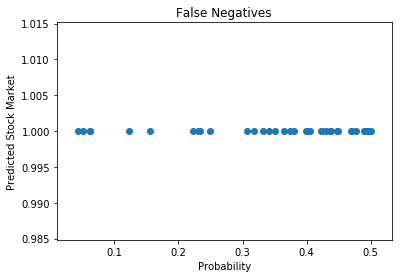

In [44]:
plt.scatter(False_Negatives.proba , False_Negatives.true_y)
plt.xlabel('Probability')
plt.ylabel('Predicted Stock Market')
plt.title('False Negatives')

## False Positives

False positives posts that were predicted to be in our positive class, but were actually in our negative class.

In [34]:
proba_df[(proba_df['true_y']==0) & (proba_df['proba']>.5)].sort_values('proba').head()

,0,proba,true_y
136,This is getting out of hand...we have got to...,0.500282,0
202,Will you buy your dream car with cryptocurre...,0.506199,0
62,"Wirex Ethereum wallet allows you to buy, sel...",0.512556,0
453,"We created an ""alt-coin correction index"". R...",0.513483,0
284,ARYZE - Winner of the 2018 Best New Danish S...,0.519111,0


## Area of low confidence

This area of low confidence is the predicted probabilty of each posts in a certain class within 5% of 50% where the random forest model was not sure whether to put a post in our positive vs negative group

In [39]:
aolc = proba_df[(proba_df['proba']>.45) & (proba_df['proba']<.55)].sort_values('proba')

##### Viewing the aeras of low confidence to see the probabilities that are closes to 50/50 to visualize the scattered points of low confidence

Text(0.5,1,'Area of low confidence')

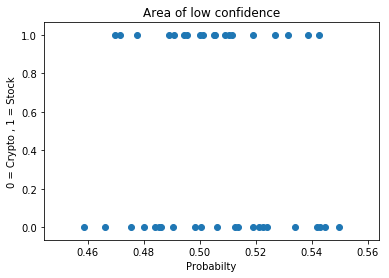

In [47]:
plt.scatter(aolc.proba , aolc.true_y)
plt.xlabel('Probabilty')
plt.ylabel('0 = Crypto , 1 = Stock' )
plt.title('Area of low confidence')